# Structure of the notebook

This notebook utilizes the pre-processed taxi trip record data.

The notebook sets the basis for **Chapter 4.2 Spatiotemporal Forecasting Models** and **Chapter 5.4 Analysis of Feature Importance:**
<ul>
    <li> Linear Mixed Effects Models (Chapter 4.2.1)</li>
    <li> Mixed Effects Random Forest (Chapter 4.2.2)</li>
    <li> Analysis of Feature Importance (Chapter 5.4)</li>
</ul>

# Libraries required to run this notebook

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from datetime import timedelta
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")
! pip install -q merf
from merf import MERF
from joblib import Parallel, delayed
! pip install -q shap
import shap

import joblib
import cloudpickle

!pip install -q geopandas
import geopandas as gpd

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit,GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Data reading and initial exploration

In [8]:
# Read the data
manhattan_final_prep = pd.read_csv("gs://final_prep_data/manhattan_spatiotemporal.csv")

# Head of the dataframe
manhattan_final_prep.tail()

,PULocationID,tpep_pickup_datetime,PU_count,lag_1h,lag_2h,lag_1d,lag_2d,PU_month,PU_day_of_month,PU_day_of_week,...,landuse_2.0,landuse_3.0,landuse_4.0,landuse_5.0,landuse_6.0,landuse_7.0,landuse_8.0,landuse_9.0,landuse_10.0,landuse_11.0
286699,263,2022-06-30 19:00:00,123.0,150.0,132.0,131.0,112.0,6,30,3,...,4025.0,1672.0,3246.0,266.0,89.0,109.0,365.0,37.0,71.0,81.0
286700,263,2022-06-30 20:00:00,100.0,123.0,150.0,103.0,95.0,6,30,3,...,4025.0,1672.0,3246.0,266.0,89.0,109.0,365.0,37.0,71.0,81.0
286701,263,2022-06-30 21:00:00,109.0,100.0,123.0,114.0,123.0,6,30,3,...,4025.0,1672.0,3246.0,266.0,89.0,109.0,365.0,37.0,71.0,81.0
286702,263,2022-06-30 22:00:00,103.0,109.0,100.0,115.0,111.0,6,30,3,...,4025.0,1672.0,3246.0,266.0,89.0,109.0,365.0,37.0,71.0,81.0
286703,263,2022-06-30 23:00:00,54.0,103.0,109.0,71.0,65.0,6,30,3,...,4025.0,1672.0,3246.0,266.0,89.0,109.0,365.0,37.0,71.0,81.0


In [3]:
# Info on the dataset
manhattan_final_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286704 entries, 0 to 286703
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   PULocationID          286704 non-null  int64  
 1   tpep_pickup_datetime  286704 non-null  object 
 2   PU_count              286704 non-null  float64
 3   lag_1h                286704 non-null  float64
 4   lag_2h                286704 non-null  float64
 5   lag_1d                286704 non-null  float64
 6   lag_2d                286704 non-null  float64
 7   PU_month              286704 non-null  int64  
 8   PU_day_of_month       286704 non-null  int64  
 9   PU_day_of_week        286704 non-null  int64  
 10  PU_hour               286704 non-null  int64  
 11  ewma_3h               286704 non-null  float64
 12  ewma_6h               286704 non-null  float64
 13  ewma_12h              286704 non-null  float64
 14  ewma_24h              286704 non-null  float64
 15  

In [9]:
# Drop least important columns with high collinearity
manhattan_final_prep.drop(['lag_2d','ewma_24h', 'PU_month', 'frost', 'income_med_e','age_med_e', 'total_pop_e', 'landuse_7.0'], axis = 1, inplace = True)

# manhattan_final_prep.drop(['lag_2d','ewma_24h', 'PU_month', 'income_med_e','age_med_e', 'total_pop_e', 'landuse_7.0'], axis = 1, inplace = True)
# manhattan_final_prep.drop(['lag_2d','ewma_24h', 'PU_month', 'frost', 'landuse_7.0'], axis = 1, inplace = True)
# manhattan_final_prep.drop(['lag_2d','ewma_24h', 'PU_month'], axis = 1, inplace = True)

In [10]:
# Mixed effect models are not able to handle columns that contain percentage (%) or decimal (.) values.
# Define a dictionary to map old column names to new column names

manhattan_final_prep_new = manhattan_final_prep.copy()
column_mapping = {
    'employment_%': 'employment_pct',
    'income_high_%': 'income_high_pct',
    'age_65_%': 'age_65_pct',
    'female_%' : 'female_pct',
    'landuse_1.0': 'landuse_1',
    'landuse_2.0': 'landuse_2',
    'landuse_3.0': 'landuse_3',
    'landuse_4.0': 'landuse_4',
    'landuse_5.0': 'landuse_5',
    'landuse_6.0': 'landuse_6',
    'landuse_8.0': 'landuse_8',
    'landuse_9.0': 'landuse_9',
    'landuse_10.0': 'landuse_10',
    'landuse_11.0': 'landuse_11'
}

# Rename the columns using the dictionary
manhattan_final_prep_new.rename(columns=column_mapping, inplace=True)

# Linear Mixed Effects Model

## Split the data into training and test set

In [11]:
# Define percentages of data to be used for training and testing
train_pct = 0.8
test_pct = 0.2

# Store the unique values of 'PULocationID' in a new dataset 
unique_pu_location_ids = manhattan_final_prep_new['PULocationID'].unique()

# Initialize two empty dataframes to store the train and test data
train_data_smf = pd.DataFrame()
test_data_smf = pd.DataFrame()

# Iterate over each unique 'PULocationID' and filter the data for that specific location
for pu_location_id in unique_pu_location_ids:
    pu_location_data = manhattan_final_prep_new[manhattan_final_prep_new['PULocationID'] == pu_location_id]

    # For each location, the data is split into train and test set
    n = len(pu_location_data)
    train_idx = int(train_pct * n)
    # For each location, the train and test data is appended to the corresponding dataframes
    train_data_smf = train_data_smf.append(pu_location_data[:train_idx])
    test_data_smf = test_data_smf.append(pu_location_data[train_idx:train_idx + int(test_pct * n)])

# Reset index for further processing
train_data_smf = train_data_smf.reset_index(drop=True)
test_data_smf = test_data_smf.reset_index(drop=True)

## Seperate explanatory features and target variable

In [12]:
# Extract predictors (X) and response variable (Y) for the train and test set
X_train = train_data_smf.drop('PU_count', axis=1)
Y_train = train_data_smf['PU_count']
X_test = test_data_smf.drop('PU_count', axis=1)
Y_test = test_data_smf['PU_count']

## Model specifications

In [9]:
# Define the formula for the fixed effect part of the model 
# The fixed effect formula is defined as the dependent variable and the datetime variables, as well as the weather data
fixed_formula = 'PU_count ~ PU_day_of_month + PU_day_of_week + PU_hour + precip + temp'

# Define the formula for the random effects part of the model
# This includes the lagged variables, exponentially weighted moving averages, sociodemographic and land-use variables
random_formula = '0 + lag_1h + lag_2h + lag_1d + ewma_3h + ewma_6h + ewma_12h + employment_pct + income_high_pct + poverty_lev_e + female_pct + age_65_pct + landuse_1 + landuse_2 + landuse_3 + landuse_4 + landuse_5 + landuse_6 + landuse_8 + landuse_9 + landuse_10 + landuse_11'

# Combine fixed and random effects formulas
formula = f'{fixed_formula} + {random_formula}'

# Fit the model with fixed and random effects
model = smf.mixedlm(formula, data=train_data_smf, groups= train_data_smf['PULocationID'])
result = model.fit(method = "powell") # The powell optimization method is used

# Print the summary of the model results
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:             MixedLM  Dependent Variable:  PU_count    
No. Observations:  229350   Method:              REML        
No. Groups:        66       Scale:               2.9046      
Min. group size:   3475     Log-Likelihood:      -448095.8036
Max. group size:   3475     Converged:           Yes         
Mean group size:   3475.0                                    
-------------------------------------------------------------
                Coef.  Std.Err.     z     P>|z| [0.025 0.975]
-------------------------------------------------------------
PU_day_of_month  0.001    0.000     2.091 0.036  0.000  0.002
PU_day_of_week  -0.071    0.002   -39.207 0.000 -0.075 -0.068
PU_hour          0.021    0.001    36.586 0.000  0.020  0.023
precip           0.042    0.005     7.947 0.000  0.031  0.052
temp            -0.024    0.000   -52.341 0.000 -0.025 -0.023
lag_1h          -0.414    0.000 -1311.721 0.000 -0.415 -0.414
lag_2h          -0.211    0.000  -817.121 0.000 -0.211 -0.210
lag_1d          -0.005    0.000   -40.063 0.000 -0.005 -0.005
ewma_3h          2.645    0.001  3566.139 0.000  2.644  2.647
ewma_6h         -1.422    0.001  -954.849 0.000 -1.425 -1.419
ewma_12h         0.427    0.001   491.011 0.000  0.425  0.429
employment_pct   0.021    0.016     1.330 0.183 -0.010  0.052
income_high_pct -0.031    0.016    -1.889 0.059 -0.063  0.001
poverty_lev_e   -0.000    0.000    -1.112 0.266 -0.000  0.000
female_pct      -0.007    0.016    -0.417 0.677 -0.038  0.025
age_65_pct      -0.051    0.024    -2.105 0.035 -0.098 -0.004
landuse_1       -0.000    0.000    -1.224 0.221 -0.000  0.000
landuse_2        0.000    0.000     0.214 0.830 -0.000  0.000
landuse_3        0.000    0.000     0.025 0.980 -0.000  0.000
landuse_4        0.000    0.000     1.841 0.066 -0.000  0.000
landuse_5       -0.000    0.000    -2.201 0.028 -0.000 -0.000
landuse_6       -0.002    0.001    -1.882 0.060 -0.005  0.000
landuse_8       -0.000    0.000    -0.822 0.411 -0.001  0.001
landuse_9        0.001    0.001     1.016 0.310 -0.001  0.002
landuse_10       0.001    0.001     1.251 0.211 -0.001  0.002
landuse_11       0.000    0.001     0.375 0.708 -0.001  0.001
Group Var        0.605    0.075                              
=============================================================

"""

## Predictions and performance evaluation

In [10]:
# Use the fitted model to make predictions on the training and test data
y_pred_smf_train = result.predict(X_train)
y_pred_smf_test = result.predict(X_test)

# Calculate and print the RMSE and MAE for the training data
mae_train_smf = mean_absolute_error(Y_train, y_pred_smf_train)
rmse_train_smf = np.sqrt(mean_squared_error(Y_train, y_pred_smf_train))
print(f"MAE for Training Set: {mae_train_smf:.2f}")
print(f"RMSE for Training Set: {rmse_train_smf:.2f}")

# Calculate and print the RMSE and MAE for the test data
mae_test_smf = mean_absolute_error(Y_test, y_pred_smf_test)
rmse_test_smf = np.sqrt(mean_squared_error(Y_test, y_pred_smf_test))
print(f"MAE for Test Set: {mae_test_smf:.2f}")
print(f"RMSE for Test Set: {rmse_test_smf:.2f}")

MAE for Training Set: 1.08
RMSE for Training Set: 1.83
MAE for Test Set: 1.18
RMSE for Test Set: 1.63


## Performance results visualization

### Dataframe of the actual versus predicted values for the test set

In [11]:
# A dataframe of the actual versus predicted values for the test set is created

# Round predicted values to integers
y_pred_smf_test_rounded = y_pred_smf_test.round().astype(int)

# Create the dataframe of the actual and rounded predicted values
lme_actual_vs_predicted = pd.DataFrame({'PULocationID': X_test['PULocationID'],
                                       'tpep_pickup_datetime': X_test['tpep_pickup_datetime'],
                                       'Actual_Pickups': Y_test,
                                       'Predicted_Pickups': y_pred_smf_test_rounded})

# Print the dataframe
print(lme_actual_vs_predicted)

       PULocationID tpep_pickup_datetime  Actual_Pickups  Predicted_Pickups
0                 4  2022-05-25 19:00:00             8.0                  8
1                 4  2022-05-25 20:00:00             7.0                  7
2                 4  2022-05-25 21:00:00             1.0                  1
3                 4  2022-05-25 22:00:00             5.0                  5
4                 4  2022-05-25 23:00:00             5.0                  5
...             ...                  ...             ...                ...
57283           263  2022-06-30 18:00:00           150.0                148
57284           263  2022-06-30 19:00:00           123.0                121
57285           263  2022-06-30 20:00:00           100.0                 99
57286           263  2022-06-30 21:00:00           109.0                110
57287           263  2022-06-30 22:00:00           103.0                104

[57288 rows x 4 columns]


### Time series plot of the actual versus predicted values for 10 sampled locations

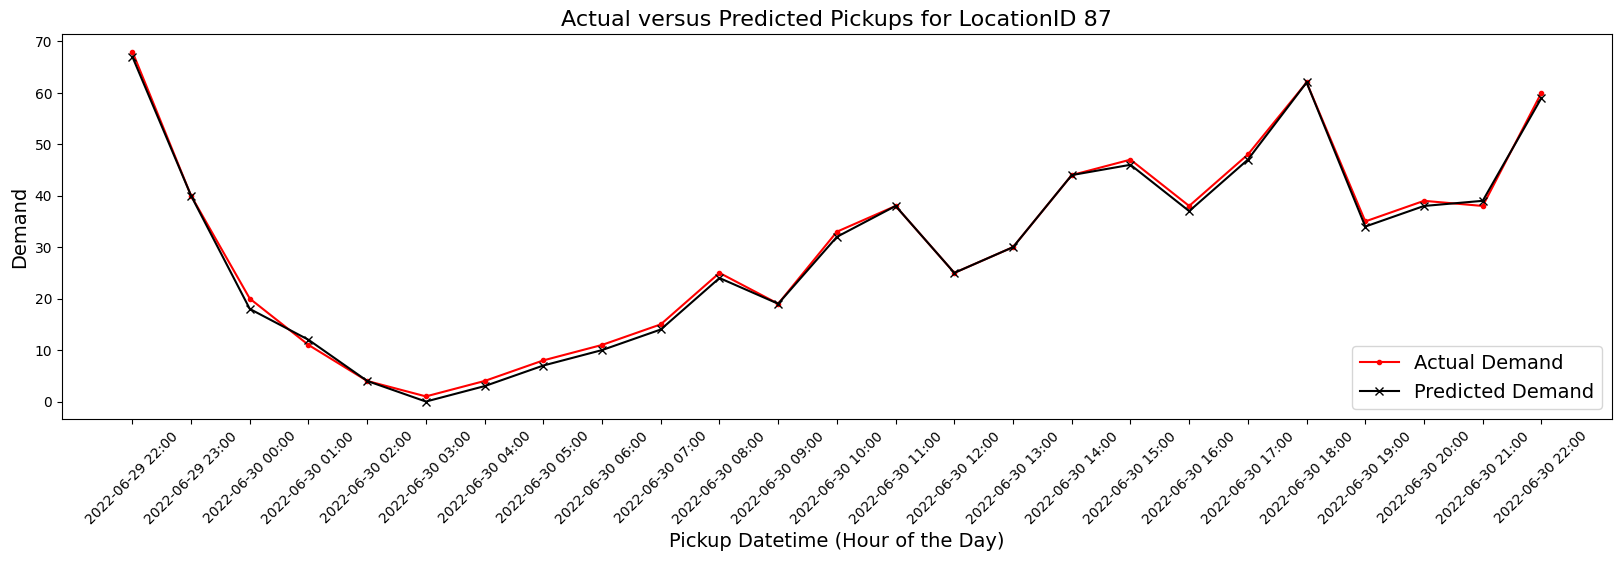

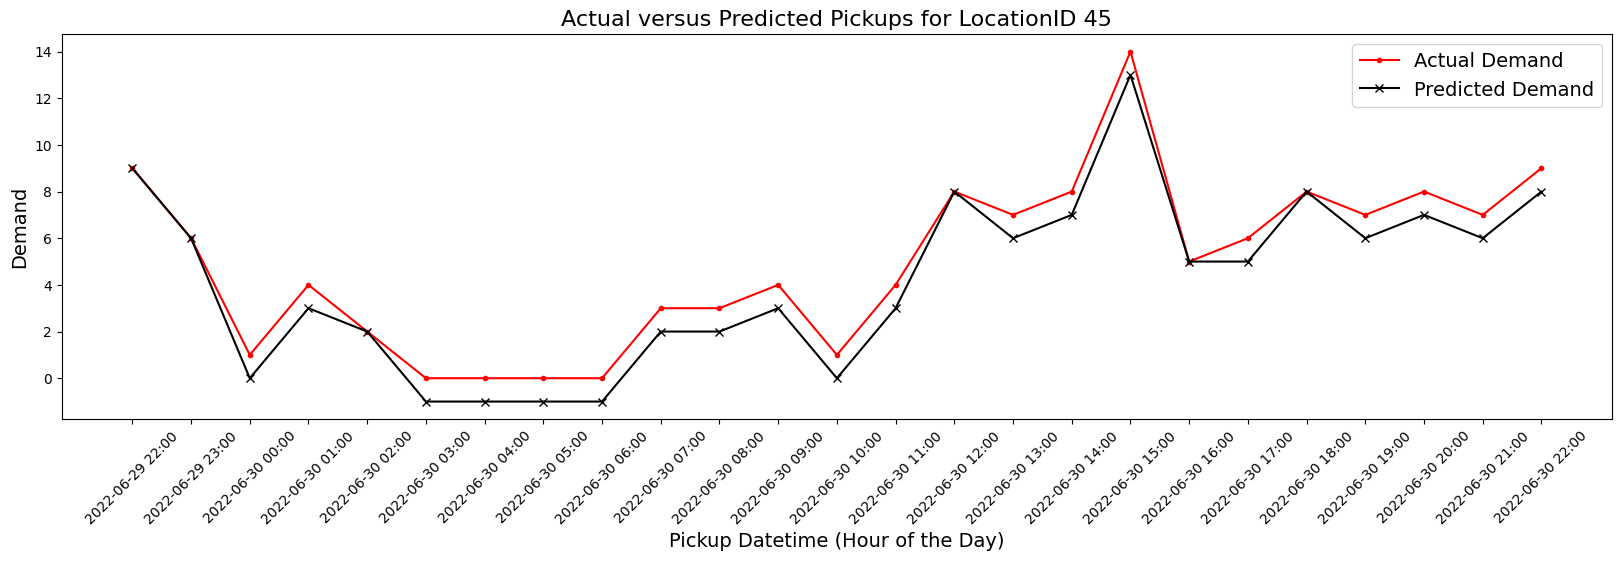

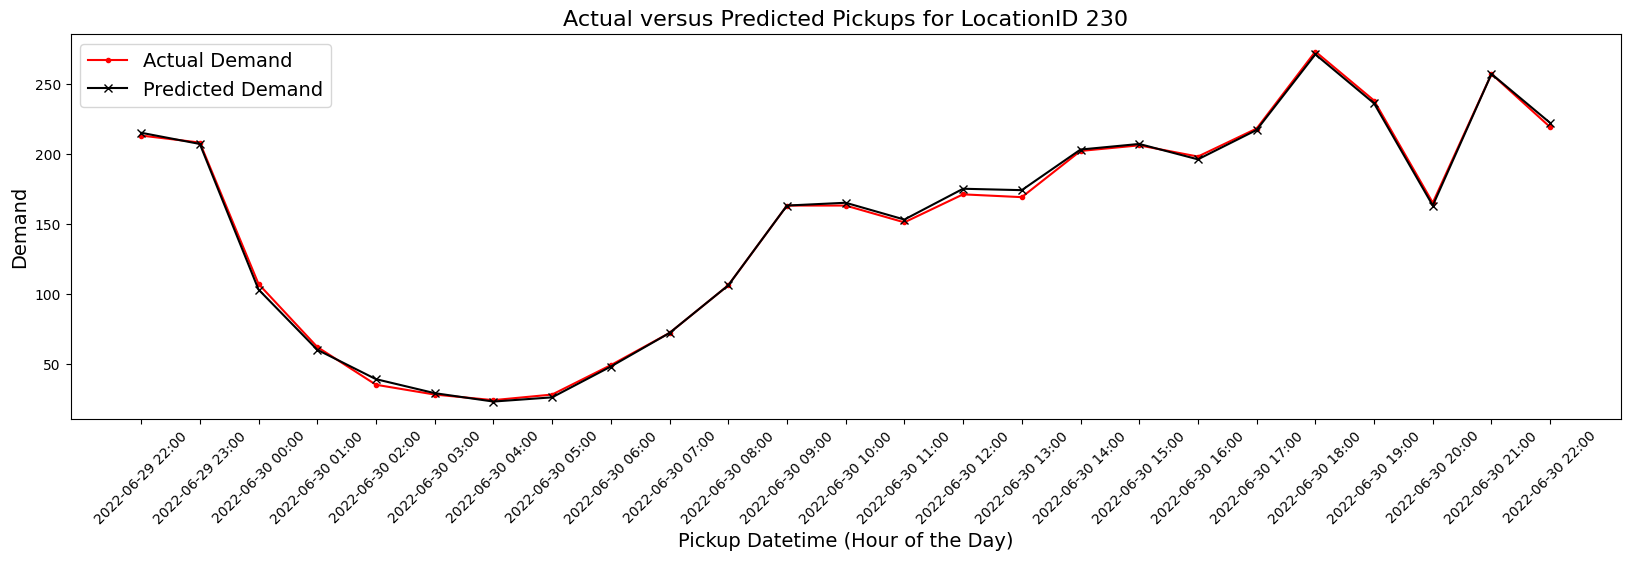

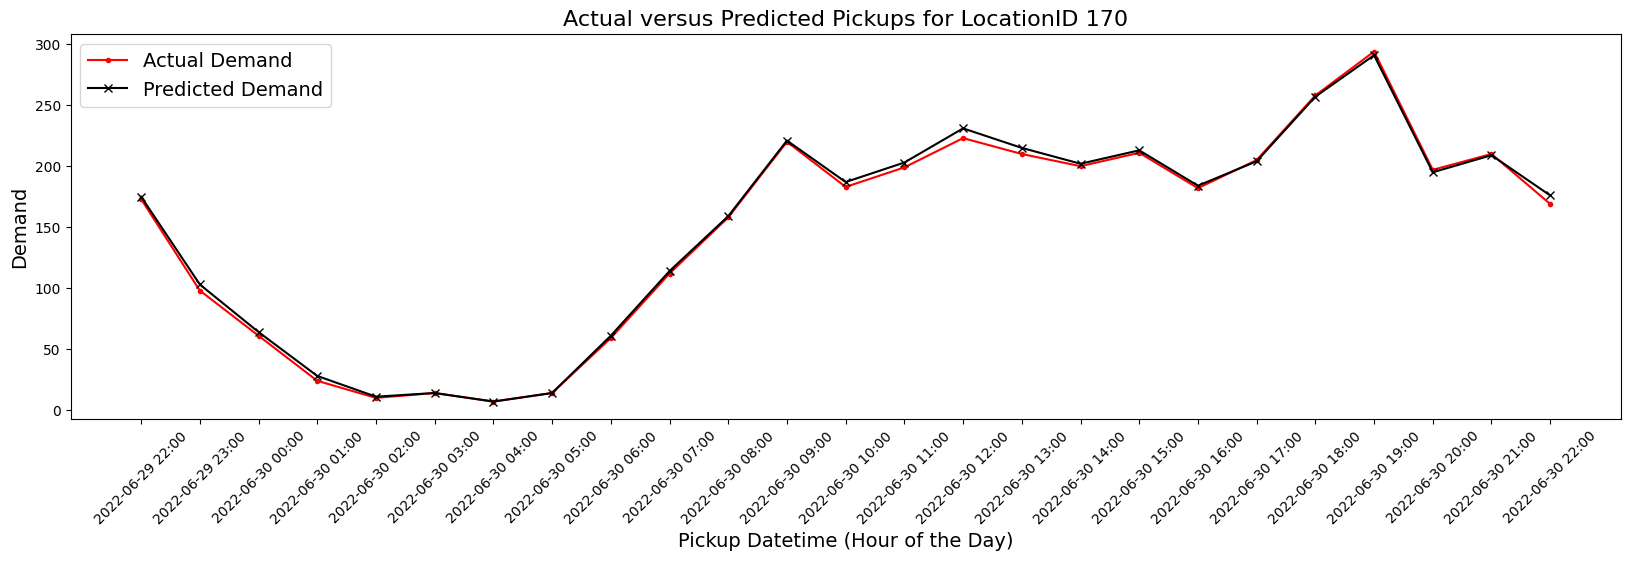

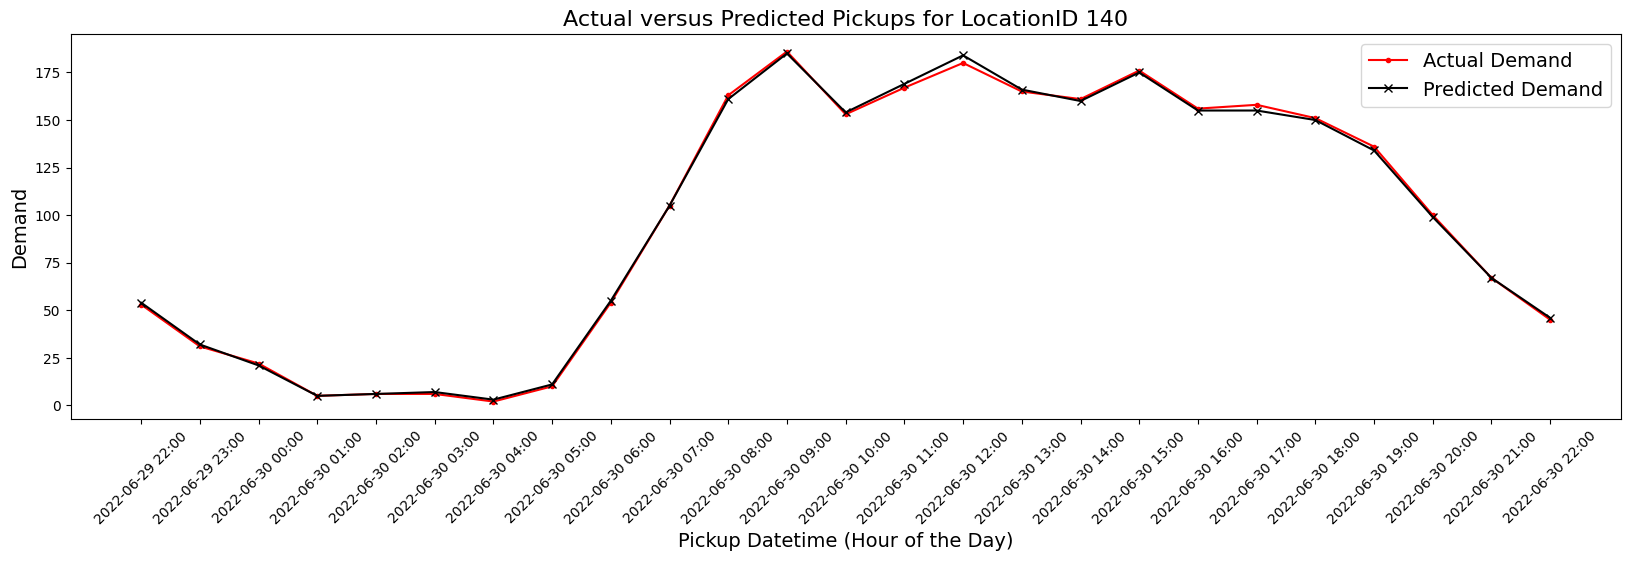

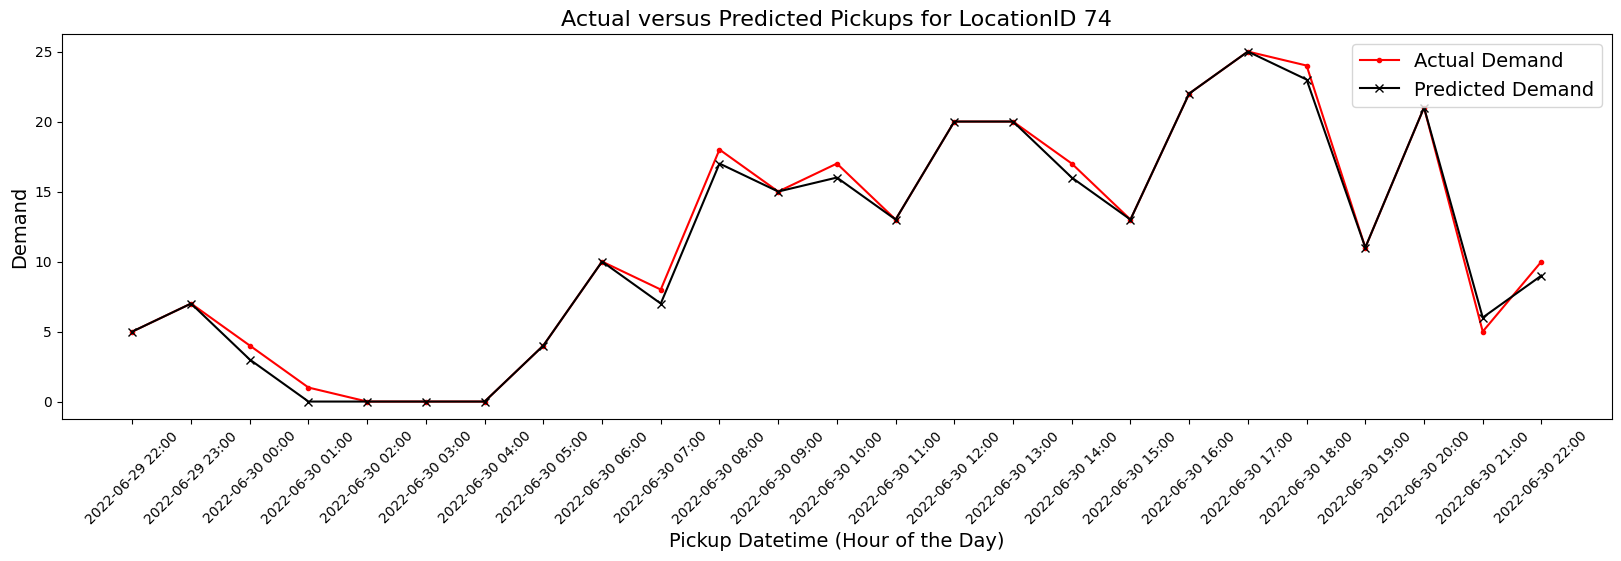

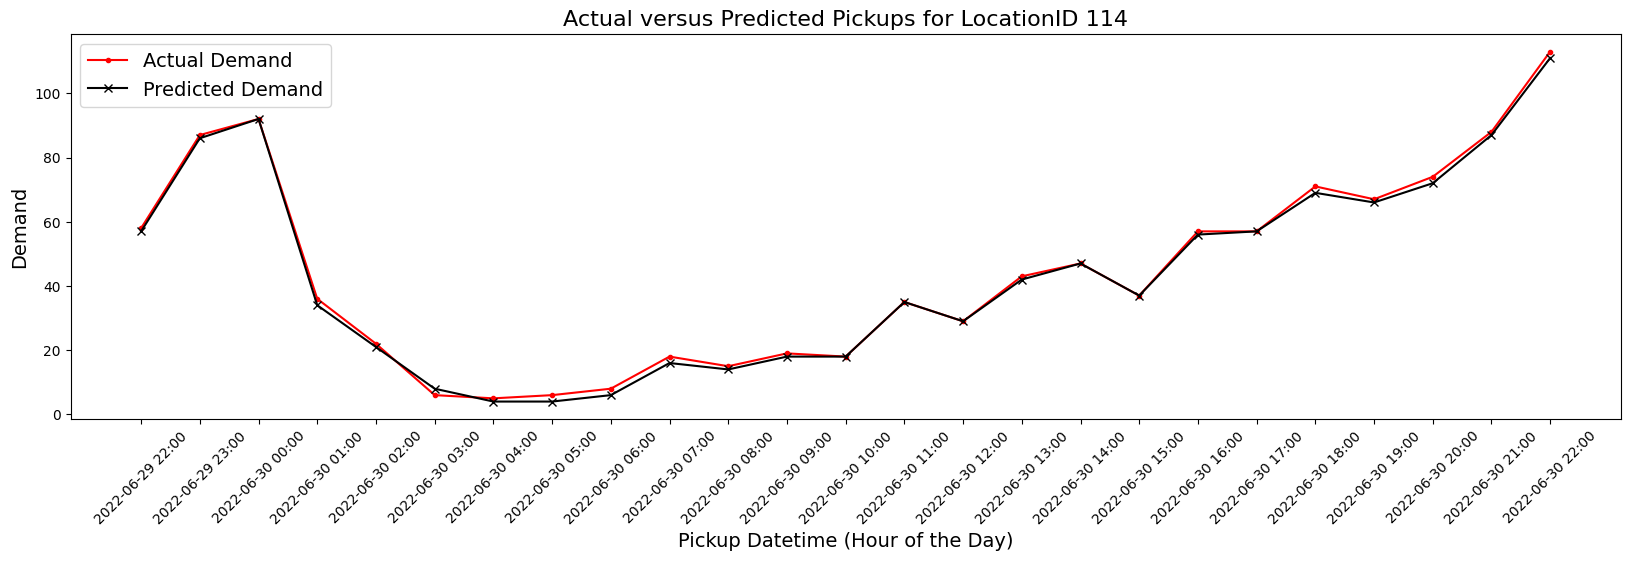

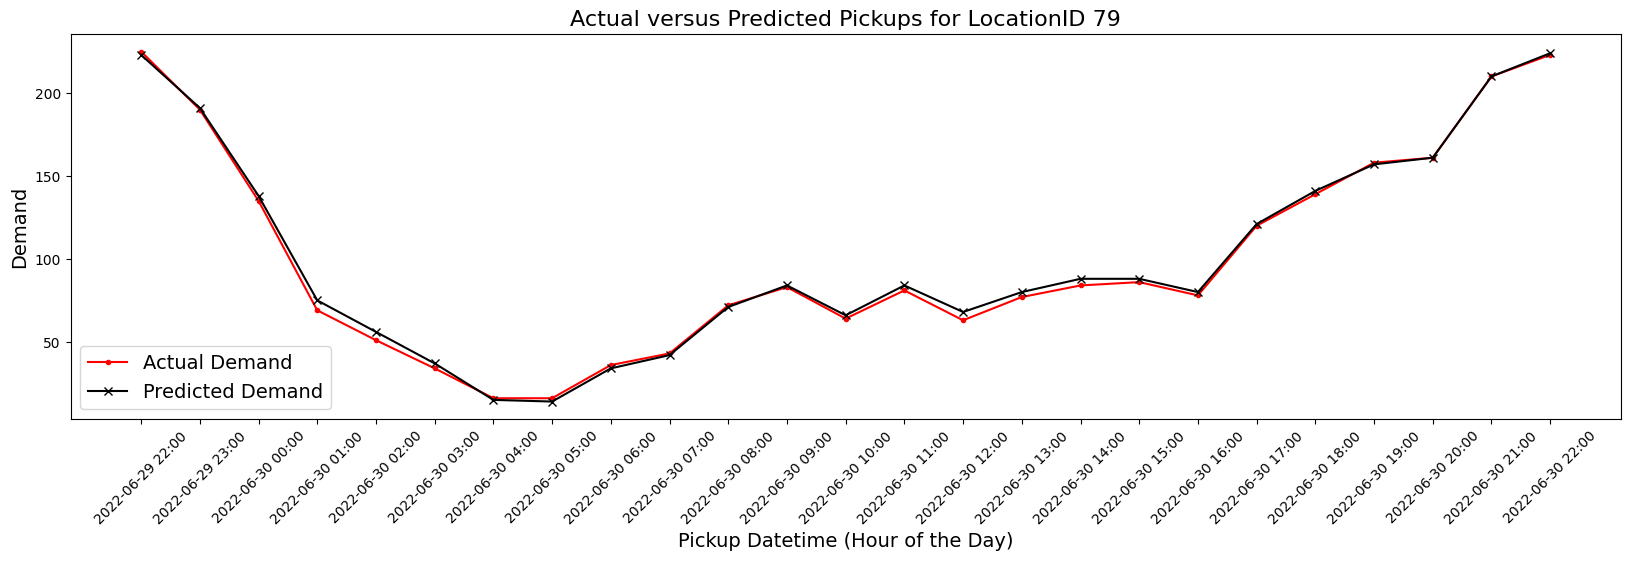

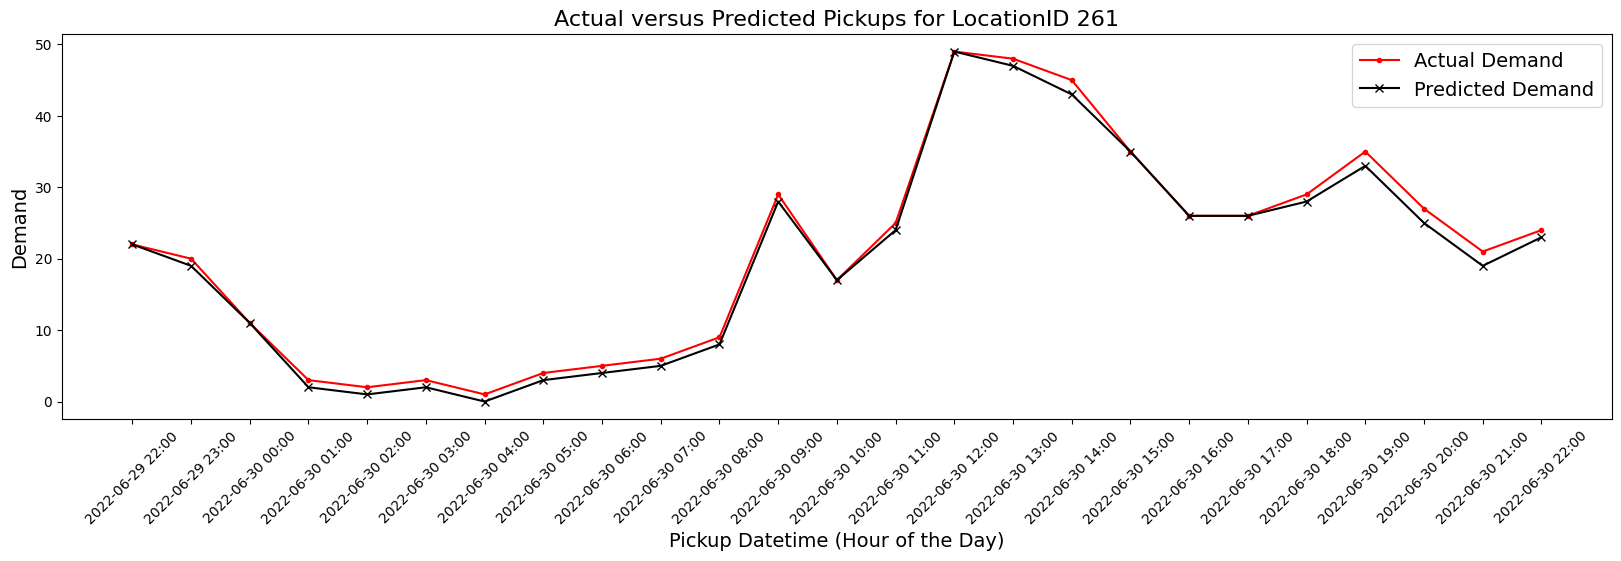

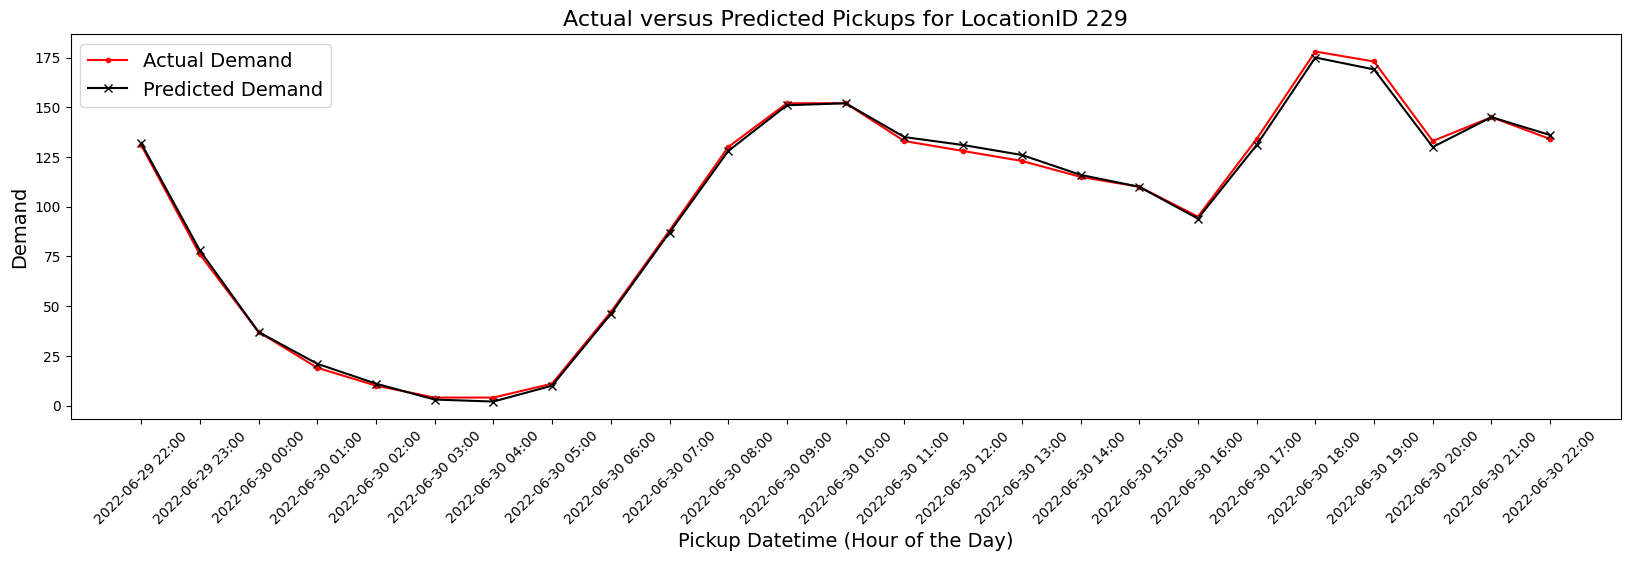

In [12]:
# Sample ten locations and create a time series plot of the actual versus predicted values over the last 24 hours of the test set

# Convert 'tpep_pickup_datetime' to datetime type
lme_actual_vs_predicted['tpep_pickup_datetime'] = pd.to_datetime(lme_actual_vs_predicted['tpep_pickup_datetime'])

# Get the latest datetime value in the dataframe
latest_datetime = lme_actual_vs_predicted['tpep_pickup_datetime'].max()

# Calculate the datetime value for 24 hours before the latest datetime value
one_day = timedelta(days=1)
start_datetime = latest_datetime - one_day

# Sample ten pickup locations
sampled_ids = np.random.choice(unique_pu_location_ids, 10, replace=False)

# Filter the sampled 'PULocationIDs' for the last 24 hours from the latest datetime value
filtered_df = lme_actual_vs_predicted[(lme_actual_vs_predicted['PULocationID'].isin(sampled_ids)) & 
                                      (lme_actual_vs_predicted['tpep_pickup_datetime'] >= start_datetime)]

# Loop through each sampled 'PULocationID' and create a time series plot
for puloc_id in sampled_ids:
    # Filter the data for the current PULocationID
    puloc_df = filtered_df[filtered_df['PULocationID'] == puloc_id]
    
    # Create a new figure for the plot
    plt.figure(figsize=(20, 5))
    # Line plot of the actual demand
    plt.plot(puloc_df['tpep_pickup_datetime'], puloc_df['Actual_Pickups'], label='Actual Demand', marker = ".", color = 'red')
    # Line plot of the predicted demand
    plt.plot(puloc_df['tpep_pickup_datetime'], puloc_df['Predicted_Pickups'], label='Predicted Demand', marker = "x", color = 'black')
    plt.xlabel('Pickup Datetime (Hour of the Day)', fontsize = 14)
  
    # Set the x-axis tick locations from the 'tpep_pickup_datetime' column
    xticks = puloc_df['tpep_pickup_datetime']
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(xticks, rotation=45)

    plt.ylabel('Demand', fontsize = 14)
    plt.title(f'Actual versus Predicted Pickups for LocationID {puloc_id}', fontsize = 16)
    plt.legend(fontsize =14)
    plt.show()

### Spatial distribution of RMSE error

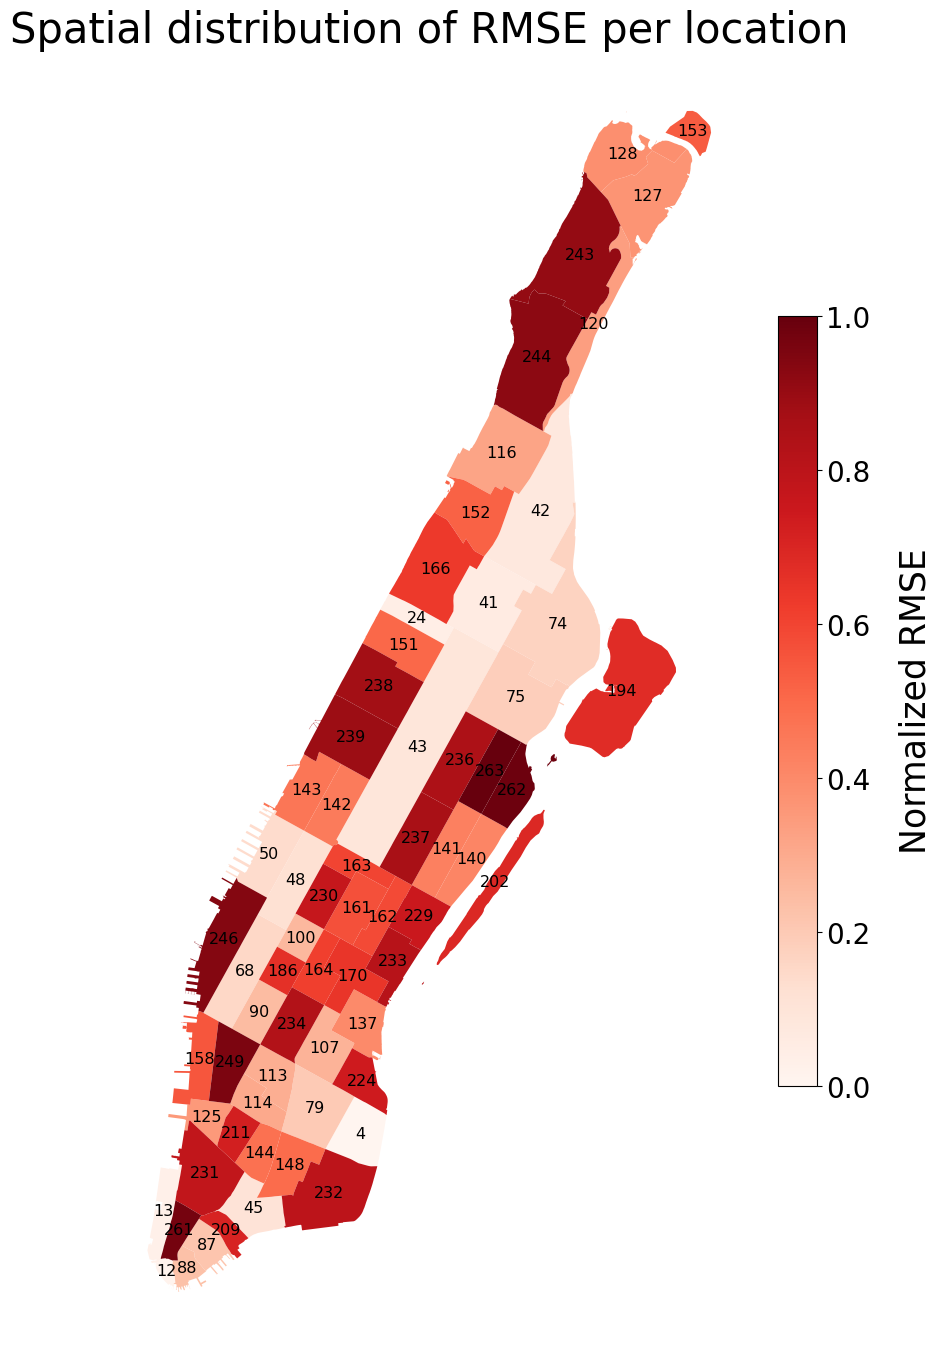

In [12]:
# Next, the performance errors (RMSE) across each 'PULocation' should be visualized
# Therefore, the dataframe 'taxi_zones' is imported as it provides information on the geographic boundaries of each taxi zone

# Import the taxi_zones dataframe
taxi_zones = gpd.read_file('gs://taxi_data_outl/taxi_zones/taxi_zones.shp')

# Calculate the RMSE for each PULocationID
df_rmse = lme_actual_vs_predicted.groupby('PULocationID').agg({'Actual_Pickups': np.mean, 
                                                              'Predicted_Pickups': np.mean}) 
df_rmse['RMSE'] = np.sqrt(((df_rmse['Actual_Pickups'] - df_rmse['Predicted_Pickups']) ** 2))

# Merge the geospatial information ('taxi_zones') with the RMSE data for each location ('df_rmse')
merged_df = df_rmse.merge(taxi_zones[['LocationID', 'geometry']], left_on='PULocationID', right_on='LocationID')
merged_df['RMSE_norm'] = (merged_df['RMSE'] - merged_df['RMSE'].min()) / (merged_df['RMSE'].max() - merged_df['RMSE'].min())
merged_df = gpd.GeoDataFrame(merged_df, geometry='geometry')

# Create the map
fig, ax = plt.subplots(figsize=(10, 50))
merged_df.plot( cmap='Reds', linewidth=0.8, ax=ax)
ax.axis('off')

# Add a normalized colorbar
# Calculate the minimum and maximum values of the 'RMSE_norm' column. These values will be used to normalize the colorbar
vmin, vmax = merged_df['RMSE_norm'].min(), merged_df['RMSE_norm'].max()
# Create a ScalarMappable object with the colormap and the normalization range
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# Set the array of the ScalarMappable object to an empty list
sm._A = []

# Create a colorbar and shrink the size of the colorbar relative to the figure size
cbar = fig.colorbar(sm, shrink=0.2)

# Set the label for the colorbar axis, the fontsize, labelpad and tick label size
cbar.ax.set_ylabel('Normalized RMSE', fontsize=25, labelpad=20)
cbar.ax.tick_params(labelsize=20)

# Add 'LocationID' labels
# Initiate a loop that iterates over the rows of the 'merged_df' dataframe
for idx, row in merged_df.iterrows():
    # Add a text annotation to the axes object and specify the position
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, str(row.LocationID), ha='center', va='center', fontsize=11.5)

# Plot the title and save the figure
plt.title('Spatial distribution of RMSE per location', fontsize = 30)
plt.savefig('RMSE Heatmap by Location.png', dpi=150, bbox_inches = 'tight')

# Show the plot
plt.show()

### Time series plot of the actual versus predicted values of a taxi zone with high RMSE (Location 202) and low RMSE (Location 43)

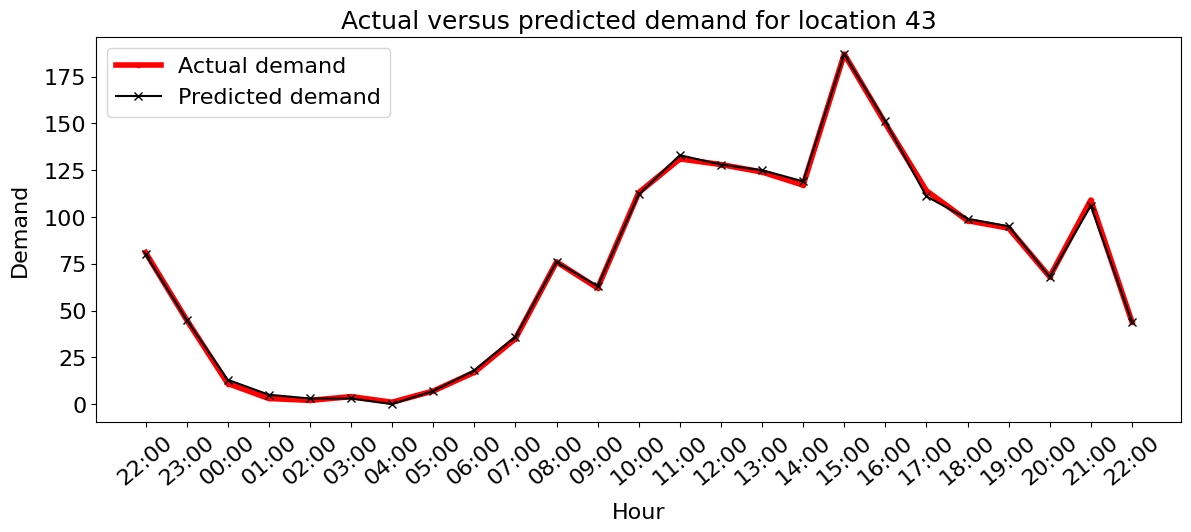

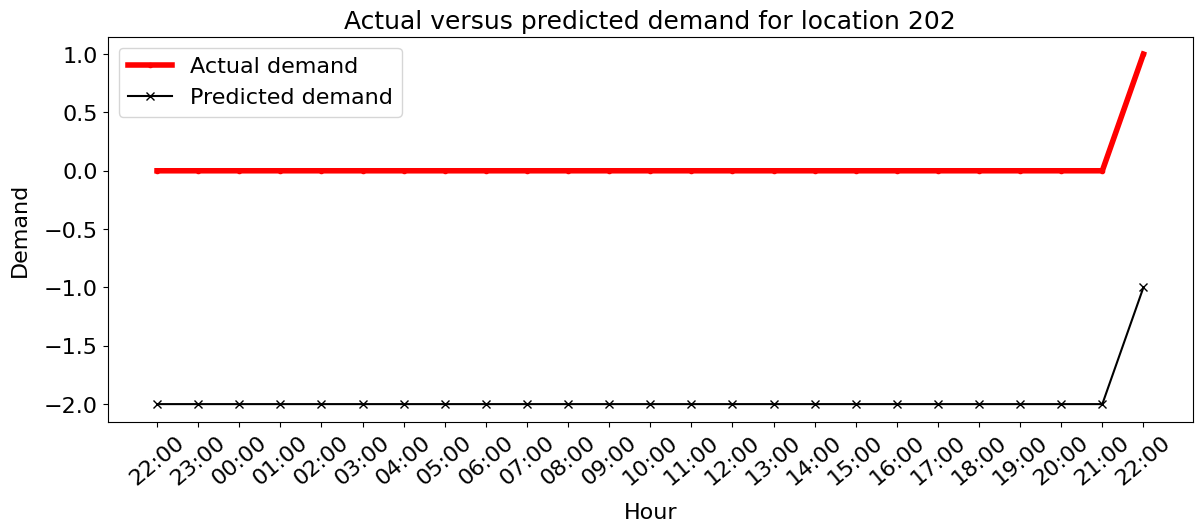

In [21]:
# Analyze the actual versus predicted demand for one location with a high RMSE value ('PULocationID' 202) and with a low RMSE value ('PULocationID' 43) in more depth
# Specify the locations to be analyzed
sampled_ids_2 = [43, 202]

# Filter the data to include only rows of the specified PULocations and the last 24 hours of the test set
filtered_df_2 = lme_actual_vs_predicted[(lme_actual_vs_predicted['PULocationID'].isin(sampled_ids_2)) & 
                                      (lme_actual_vs_predicted['tpep_pickup_datetime'] >= start_datetime)]

# Loop through each sampled PULocationID and create a time series plot
for puloc_id in sampled_ids_2:
    # Filter the data for the current PULocationID
    puloc_df = filtered_df_2[filtered_df_2['PULocationID'] == puloc_id]
    
    # Plot the time series of Actual_Pickups and Predicted_Pickups
    plt.figure(figsize=(14, 5))
    plt.plot(puloc_df['tpep_pickup_datetime'], puloc_df['Actual_Pickups'], label='Actual demand', marker = ".", color = 'red', linewidth = 4)
    plt.plot(puloc_df['tpep_pickup_datetime'], puloc_df['Predicted_Pickups'], label='Predicted demand', marker = "x", color = 'black')
    
    
    # Specification of x- and y-axis labels and ticks
    xticks = puloc_df['tpep_pickup_datetime']
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(xticks, rotation= 40, fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.ylabel('Demand', fontsize = 16, labelpad = 10)
    plt.xlabel('Hour', fontsize = 16, labelpad = 10)
    plt.title(f'Actual versus predicted demand for location {puloc_id}', fontsize = 18)
    plt.legend(fontsize =16, loc = 'upper left')
    
    plt.savefig(f'Actual_versus_predicted_demand{puloc_id}.png', bbox_inches = 'tight')
    plt.show()

## Analysis of feature importance using SHAP values

In [10]:
# Remove the 'tpep_pickup_datetime' column from the predictors in the train and test set 

X_test_a = X_test.drop('tpep_pickup_datetime', axis = 1)
X_train_a = X_train.drop('tpep_pickup_datetime', axis = 1)

**Note: The SHAP values have been saved and can be loaded in the subsequent code section due to significant runtime.**

In [26]:
# Define a lambda function to make predictions on the new data by passing the input data to the function
model_func = lambda x: result.predict(x)

# Create an explainer object
explainer = shap.Explainer(model_func, X_train_a, n_jobs = -1)

# Compute SHAP values for test data
shap_values_lme = explainer(X_test_a)

# Save the SHAP values
with open("shap_values_lme.joblib", "wb") as f:
    cloudpickle.dump(shap_values_lme, f)

Permutation explainer: 57289it [6:03:22,  2.63it/s]                             


In [15]:
# Load the SHAP values
with open("shap_values_lme.joblib", "rb") as f:
    shap_values_lme = joblib.load(f)

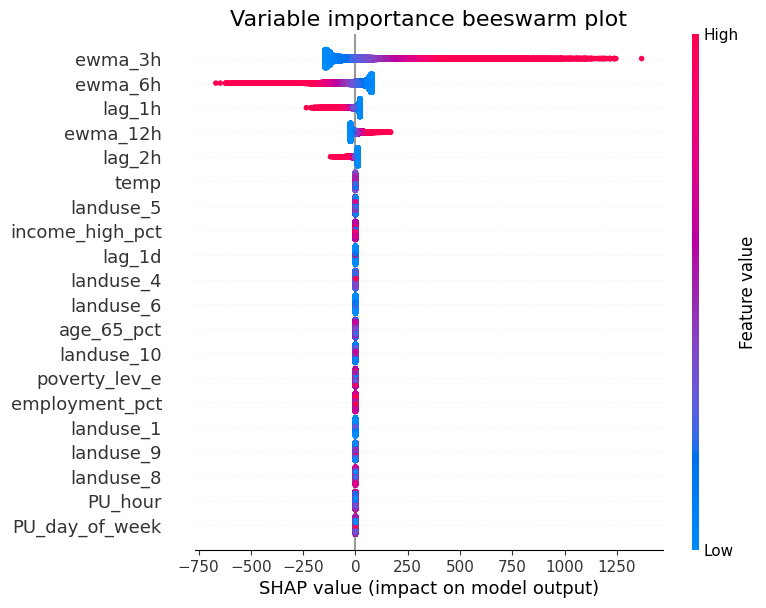

In [20]:
# Visualize SHAP values using a swarm plot
shap.summary_plot(shap_values_lme,  X_test_a, plot_size=(8, 6), show = False)
plt.title('Variable importance beeswarm plot', fontsize = 16)
plt.savefig('Swarmplot_LME', bbox_inches = 'tight')

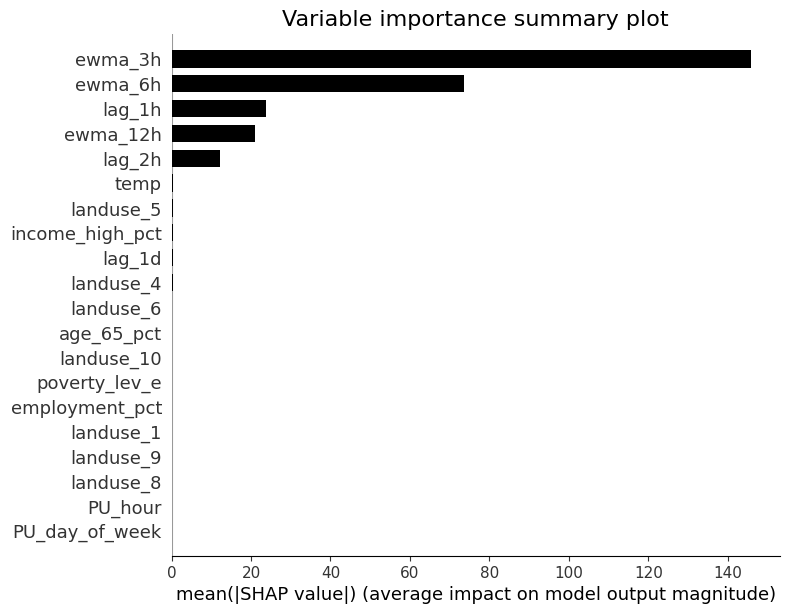

In [21]:
# Visualization of SHAP values using a summary plot
shap.summary_plot(shap_values_lme, X_test_a, plot_type = "bar", color = 'black', plot_size = (8,6), show = False)
plt.title('Variable importance summary plot', fontsize = 16)
plt.savefig('Summaryplot_LME', bbox_inches = 'tight')

# Mixed Effects Random Forest

## Split the data in training and test set

In [14]:
# Store the unique values of 'PULocationID' in a new dataset
unique_pu_location_ids = manhattan_final_prep_new['PULocationID'].unique()

# Initialize two empty dataframes to store the train and test data
train_data_merf = pd.DataFrame() 
test_data_merf = pd.DataFrame() 

# Iterate over each unique 'PULocationID' and filter the data for that specific location
for pu_location_id in unique_pu_location_ids:
    pu_location_data = manhattan_final_prep_new[manhattan_final_prep_new['PULocationID'] == pu_location_id]  # Filter data for each PULocationID

     # For each location, the data is split into train and test set
    n = len(pu_location_data)
    train_idx = int(train_pct * n)
    # For each location, the train and test data is appended to the corresponding dataframes
    train_data_merf = train_data_merf.append(pu_location_data[:train_idx])
    test_data_merf = test_data_merf.append(pu_location_data[train_idx:train_idx + int(test_pct * n)])

# Reset index for further processing
train_data_merf = train_data_merf.reset_index(drop=True)
test_data_merf = test_data_merf.reset_index(drop=True)

In [15]:
# Shape of the training and test dataset

train_data_merf.shape, test_data_merf.shape

((229350, 29), (57288, 29))

## Specification of the Mixed Effects Random Forest Model

In [16]:
# Define the individual-level predictors that vary within each group / cluster
X_train = train_data_merf[['PU_day_of_month', 'PU_day_of_week', 'PU_hour','precip', 'temp']]

# Define the group-level predictors
Z_train = train_data_merf[['employment_pct','income_high_pct', 'poverty_lev_e', 'female_pct', 'age_65_pct', 'landuse_1', 'landuse_2', 'landuse_3', 'landuse_4','landuse_5', 'landuse_6','landuse_8', 'landuse_9', 'landuse_10', 'landuse_11']]

# Define the grouping variable, which identifies the groups to which each observation belongs to 
clusters_train = train_data_merf['PULocationID']

# Specify the target variable
y_train = train_data_merf['PU_count']

# The same steps are performed on the test data
X_test = test_data_merf[['PU_day_of_month', 'PU_day_of_week', 'PU_hour','precip', 'temp']]

Z_test = test_data_merf[['employment_pct','income_high_pct','poverty_lev_e', 'female_pct', 'age_65_pct', 'landuse_1', 'landuse_2', 'landuse_3', 'landuse_4','landuse_5', 'landuse_6','landuse_8', 'landuse_9', 'landuse_10', 'landuse_11']]

clusters_test = test_data_merf['PULocationID']
y_test = test_data_merf['PU_count']

**Note: the code snippet below can be skipped, and the model can be loaded in the subsequent section.**

In [45]:
# Fit the MERF model
mrf = MERF(max_iterations = 2)
mrf.fit(X_train, Z_train, clusters_train,y_train)

INFO     [merf.py:307] Training GLL is 1968459.9050746735 at iteration 1.
INFO     [merf.py:307] Training GLL is 1968232.9785487906 at iteration 2.


In [52]:
# Save the model and data
joblib.dump({'model': mrf, 'hyperparameters': merf_hyperparameters}, 'merf_model.joblib')

['merf_model.joblib']

In [17]:
# Load the model and associated data
saved_data = joblib.load('merf_model.joblib')
merf_model = saved_data['model']
hyperparameters = saved_data['hyperparameters']

In [18]:
# Use the trained MERF model to make predictions on the training and test set
y_train_pred = merf_model.predict(X_train, Z_train, clusters_train)
y_test_pred = merf_model.predict(X_test, Z_test, clusters_test)

# Calculate and print the MAE and RMSE on training set
mae_train = np.mean(np.abs(y_train - y_train_pred))
rmse_train = np.sqrt(np.mean((y_train - y_train_pred) ** 2))
print(f"MAE on Train set: {mae_train:.2f}")
print(f"RMSE on Train set: {rmse_train:.2f}")

# Calculate and print the MAE and RMSE on test set
mae_test = np.mean(np.abs(y_test - y_test_pred))
rmse_test = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
print(f"MAE on Test set: {mae_test:.2f}")
print(f"RMSE on Test set: {rmse_test:.2f}")

MAE on Train set: 31.56
RMSE on Train set: 44.32
MAE on Test set: 32.43
RMSE on Test set: 44.37


## Performance results visualization

### Dataframe of the actual versus predicted values for the test set

In [20]:
# Round predicted values to integers
y_test_pred = y_test_pred.round().astype(int)

# Create a new dataframe with the actual and predicted values for the test set
df_actual_vs_predicted = pd.DataFrame({
    'PULocationID': test_data_merf.loc[y_test.index, 'PULocationID'], # Add the PULocationID column from the original test data
    'tpep_pickup_datetime': test_data_merf.loc[y_test.index, 'tpep_pickup_datetime'],
    'Actual_Pickups': y_test,
    'Predicted_Pickups': y_test_pred
})

# Print the new dataframe
print(df_actual_vs_predicted)

       PULocationID tpep_pickup_datetime  Actual_Pickups  Predicted_Pickups
0                 4  2022-05-25 19:00:00             8.0                 53
1                 4  2022-05-25 20:00:00             7.0                 41
2                 4  2022-05-25 21:00:00             1.0                 38
3                 4  2022-05-25 22:00:00             5.0                 25
4                 4  2022-05-25 23:00:00             5.0                  6
...             ...                  ...             ...                ...
57283           263  2022-06-30 18:00:00           150.0                161
57284           263  2022-06-30 19:00:00           123.0                148
57285           263  2022-06-30 20:00:00           100.0                131
57286           263  2022-06-30 21:00:00           109.0                130
57287           263  2022-06-30 22:00:00           103.0                123

[57288 rows x 4 columns]


### Time series plot of the actual versus predicted values for 10 sampled locations

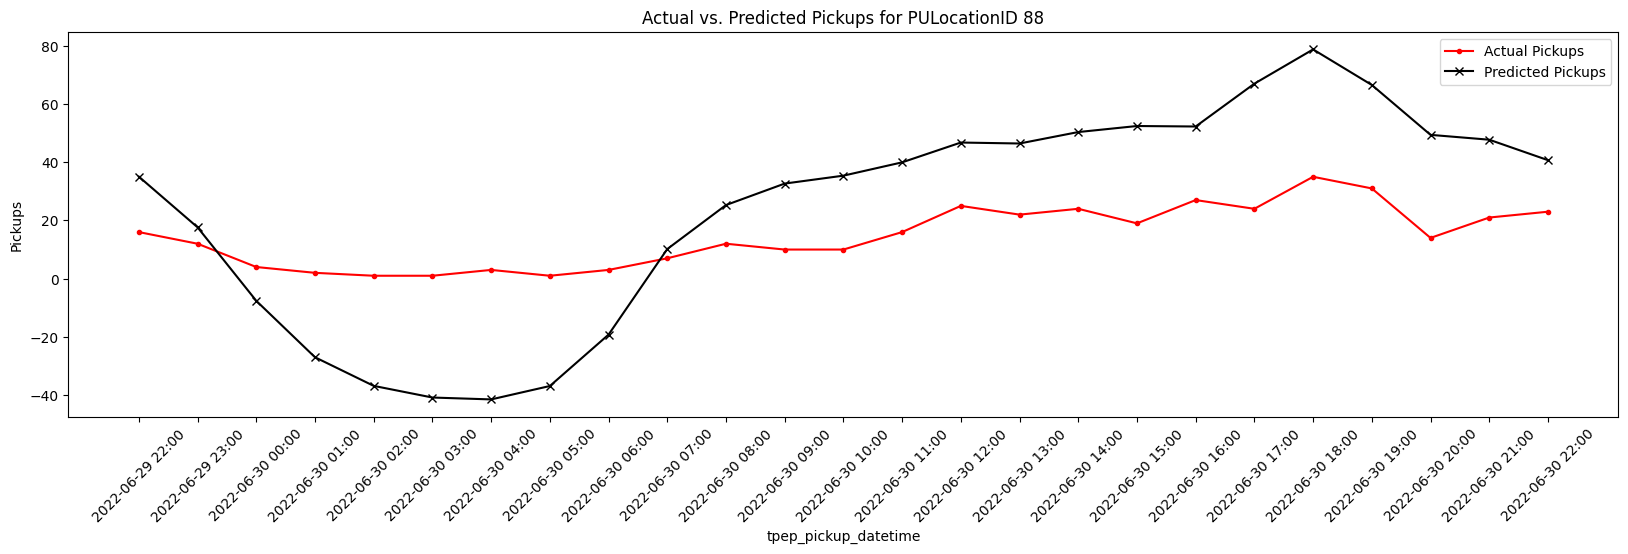

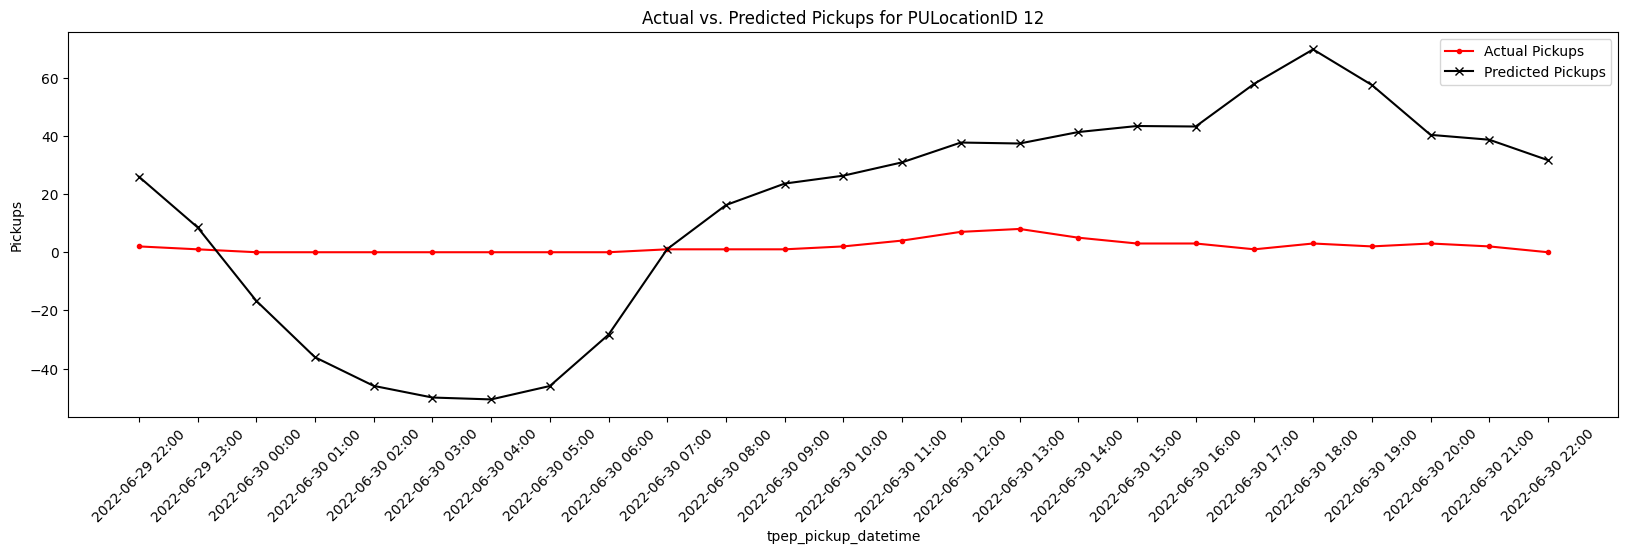

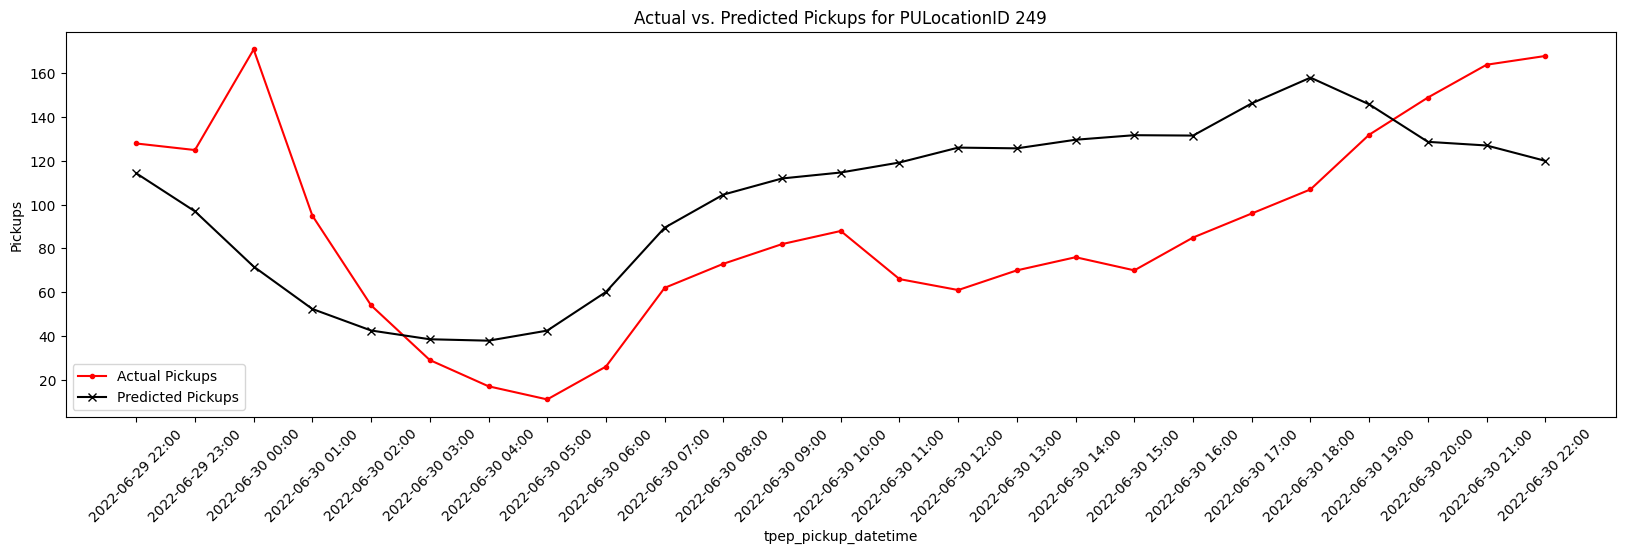

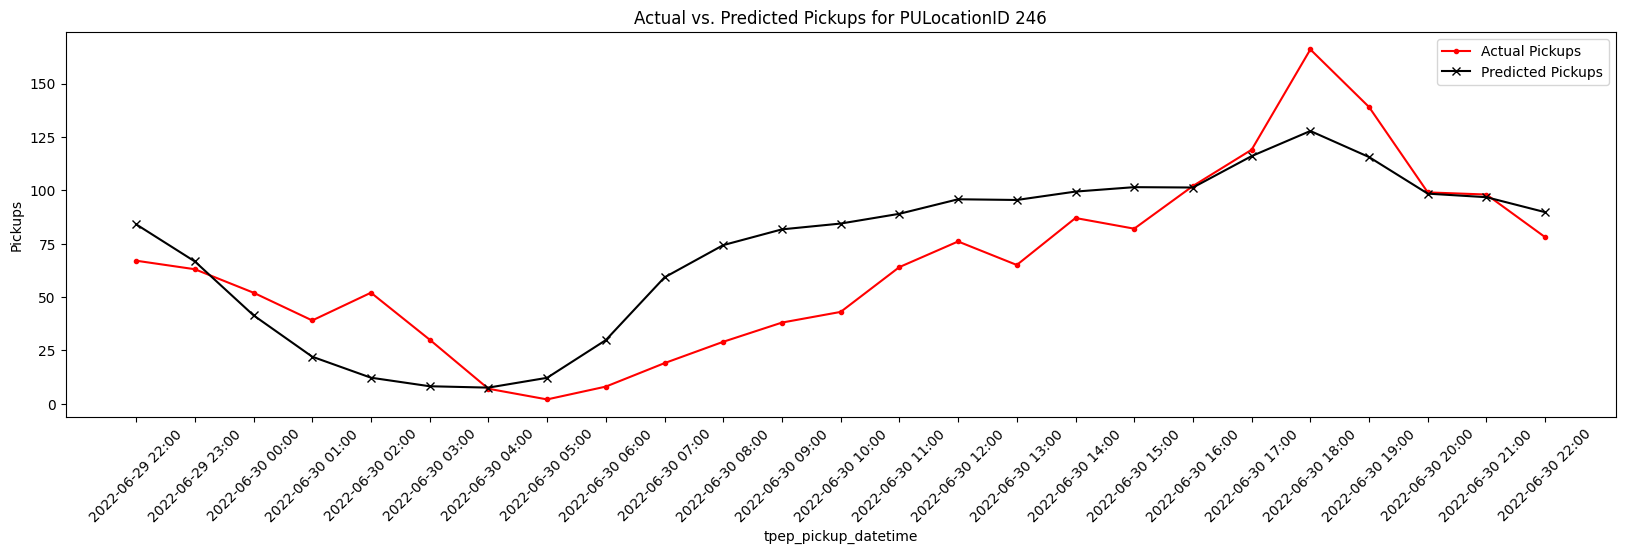

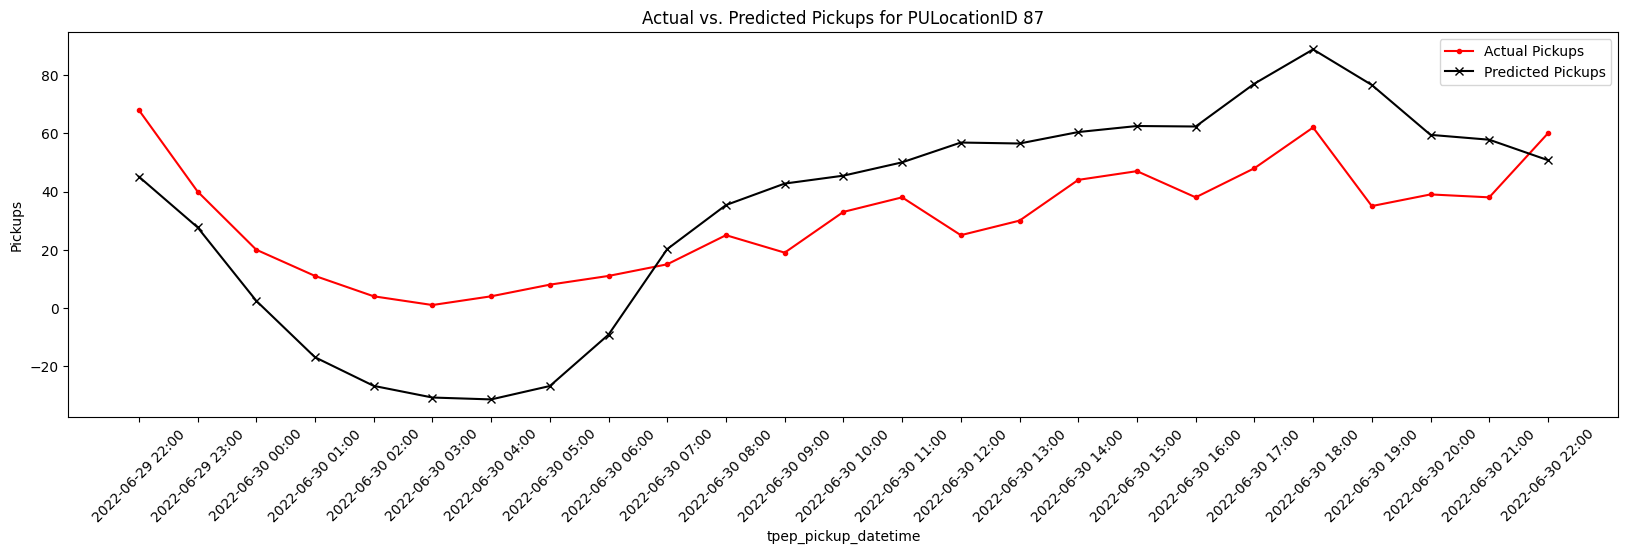

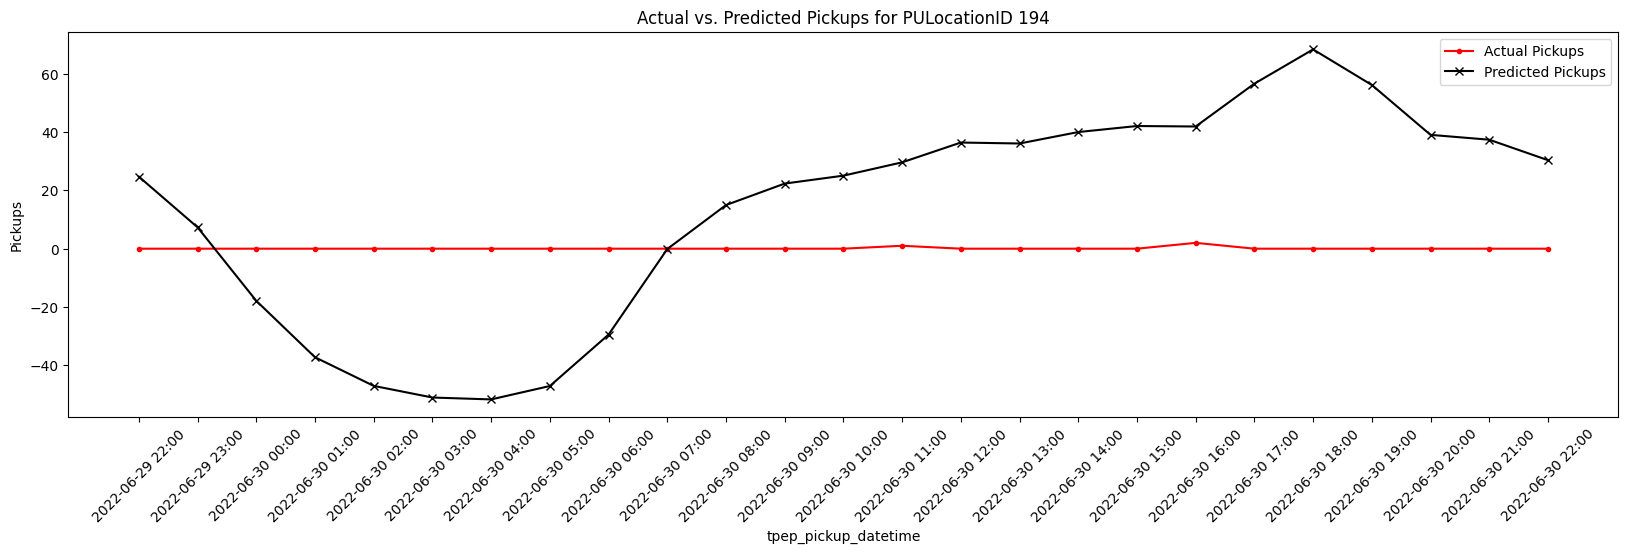

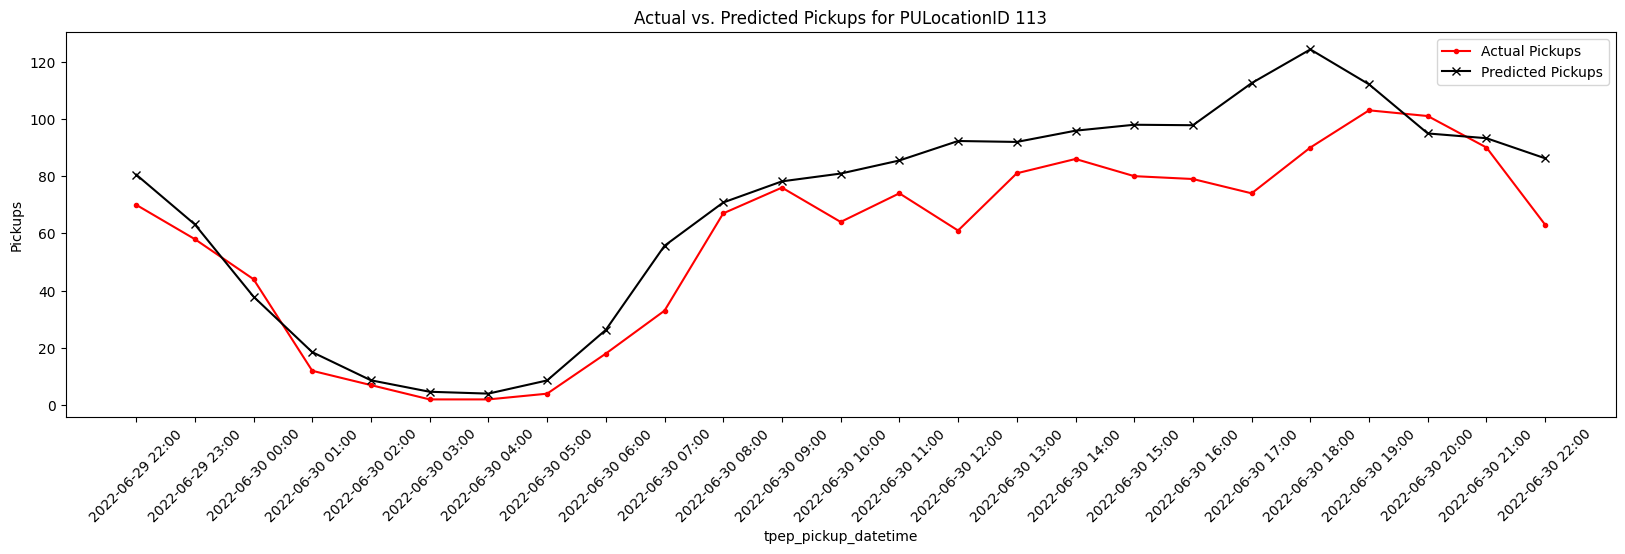

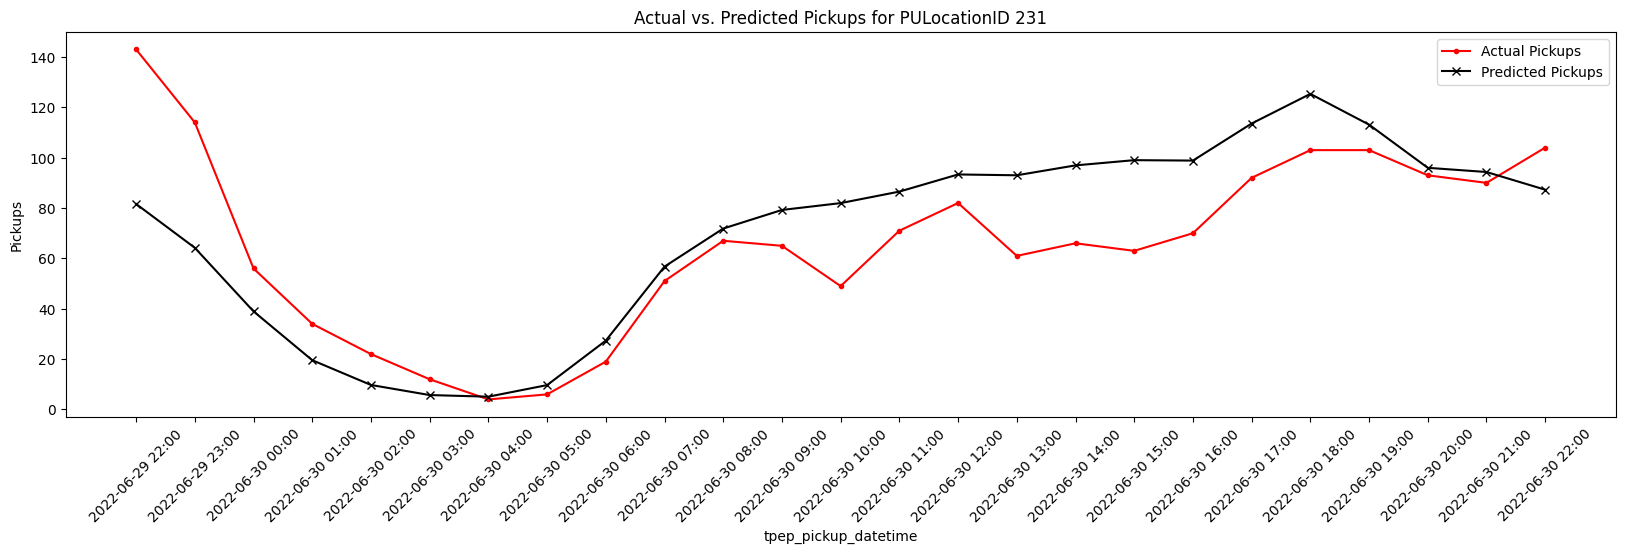

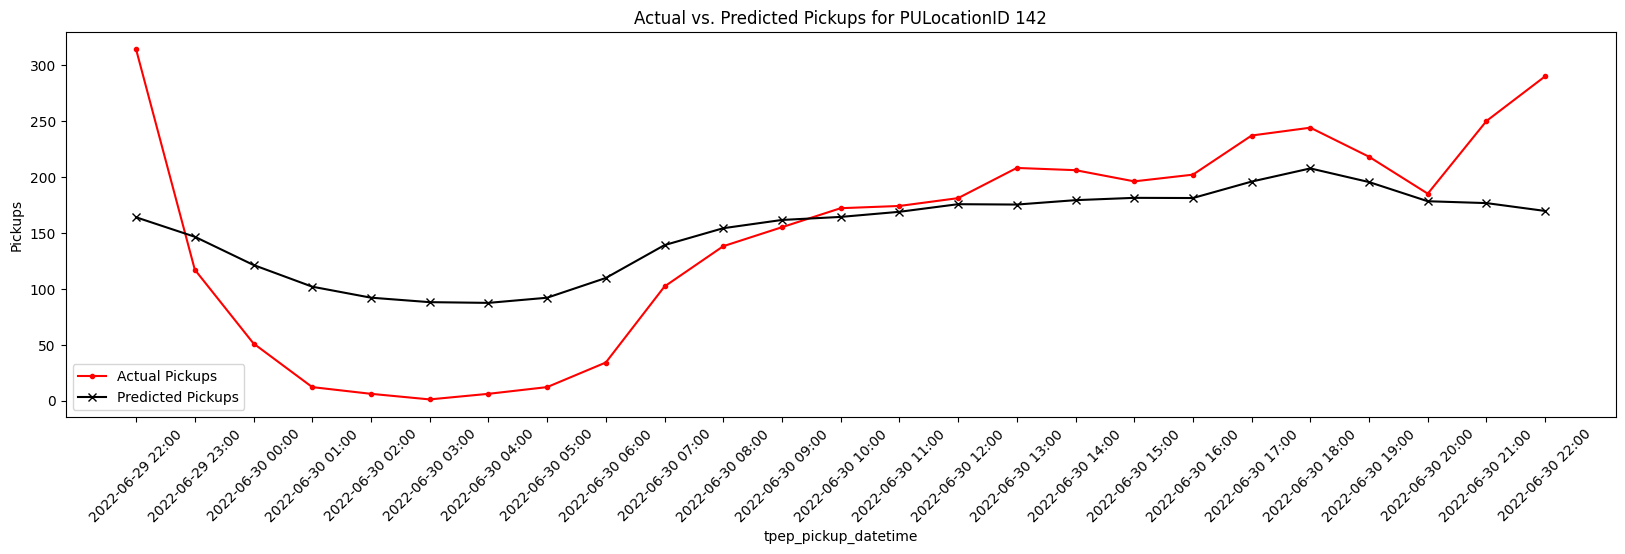

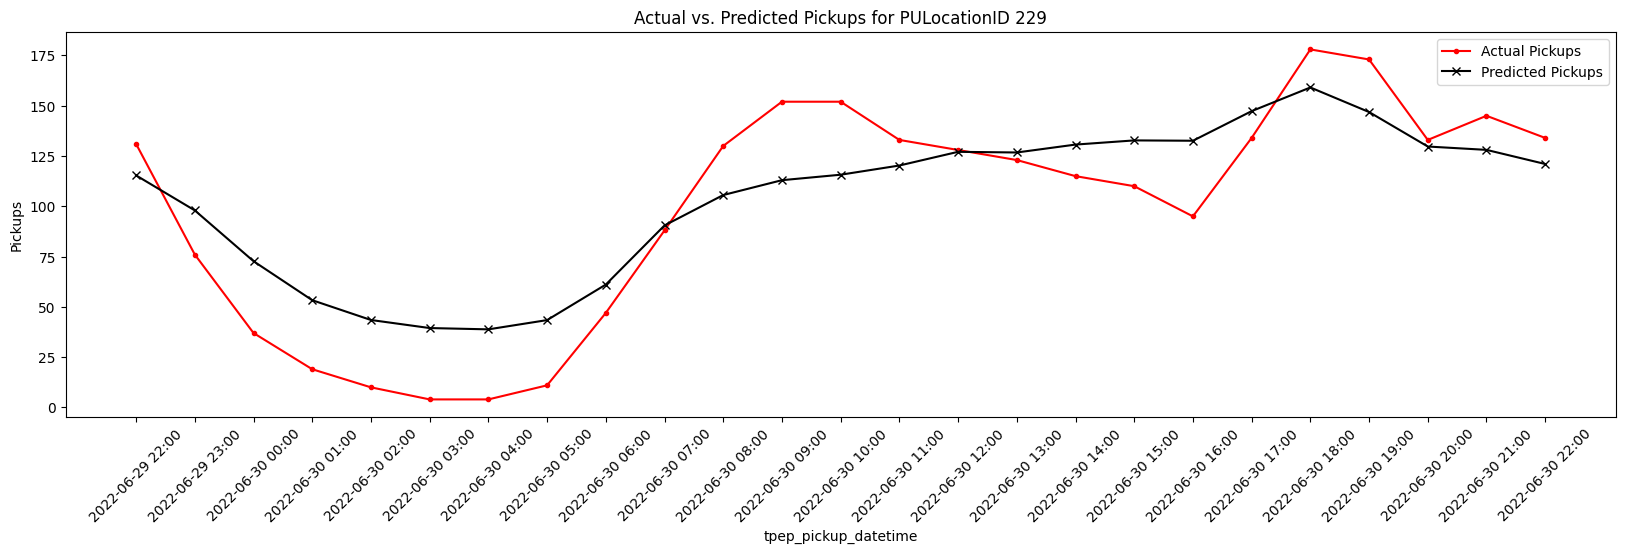

In [29]:
# Sample 10 pickup locations to create a time series plot of the actual versus predicted values over the last 24 hours of the test set

# Convert 'tpep_pickup_datetime' to datetime type if it's not already
df_actual_vs_predicted['tpep_pickup_datetime'] = pd.to_datetime(df_actual_vs_predicted['tpep_pickup_datetime'])

# Get the latest datetime value in the dataframe
latest_datetime = df_actual_vs_predicted['tpep_pickup_datetime'].max()

# Calculate the datetime value for 24 hours before the latest datetime value
one_day = timedelta(days=1)
start_datetime = latest_datetime - one_day

# Sample ten pickup location IDs 
sampled_ids = np.random.choice(unique_pu_location_ids, 10, replace=False)

# Filter the sampled 'PULocationIDs' for the last 24 hours from the latest datetime value
filtered_df = df_actual_vs_predicted[(df_actual_vs_predicted['PULocationID'].isin(sampled_ids)) & 
                                      (df_actual_vs_predicted['tpep_pickup_datetime'] >= start_datetime)]

# Group the filtered dataframe by PULocationID
grouped_df = filtered_df.groupby('PULocationID').mean()

# Reset index for further processing
grouped_df = grouped_df.reset_index()

# Loop through each sampled PULocationID and create a time series plot
for puloc_id in sampled_ids:
    # Filter the data for the current PULocationID
    puloc_df = filtered_df[filtered_df['PULocationID'] == puloc_id]
    
    # Plot the time series of Actual_Pickups and Predicted_Pickups
    plt.figure(figsize=(20, 5))
    # Plot of the actual pickups
    plt.plot(puloc_df['tpep_pickup_datetime'], puloc_df['Actual_Pickups'], label='Actual Pickups', marker = ".", color = 'red')
    # Plot of the predicted pickups
    plt.plot(puloc_df['tpep_pickup_datetime'], puloc_df['Predicted_Pickups'], label='Predicted Pickups', marker = "x", color = 'black')
    
    # Set the x-axis tick locations from the 'tpep_pickup_datetime' column
    xticks = puloc_df['tpep_pickup_datetime']
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(xticks, rotation=45)
    
    # Set the labels and titles
    plt.xlabel('tpep_pickup_datetime')
    plt.ylabel('Pickups')
    plt.title(f'Actual vs. Predicted Pickups for PULocationID {puloc_id}')
    # Plot the legend and show the plot
    plt.legend()
    plt.show()